## **Downdload and Prepare Data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !unzip "/content/gdrive/MyDrive/Image captioning/archive.zip" -d "/content/gdrive/MyDrive/Image captioning"

In [ ]:
import keras
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import sys, time, os, warnings
import re
import random
import json
import pickle
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

from collections import Counter 
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.python.keras.backend import set_session
from glob import glob
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
from keras.applications.resnet import ResNet101, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import load_img, img_to_array


In [ ]:
dir_Flickr_jpg = "/content/gdrive/MyDrive/Image captioning/Images"

dir_Flickr_text = "/content/gdrive/MyDrive/Image captioning/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 16196


In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split(',')
    if len(col) == 1:
        continue
    w = col[0].split(",")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","caption"])
uni_filenames = np.unique(data.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

data.head(10)

The number of unique file names : 8092
The distribution of the number of captions for each image:


,filename,caption
0,image,caption
1,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
2,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
3,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
4,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
5,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
6,1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting
7,1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with...
8,1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots a...
9,1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each o...


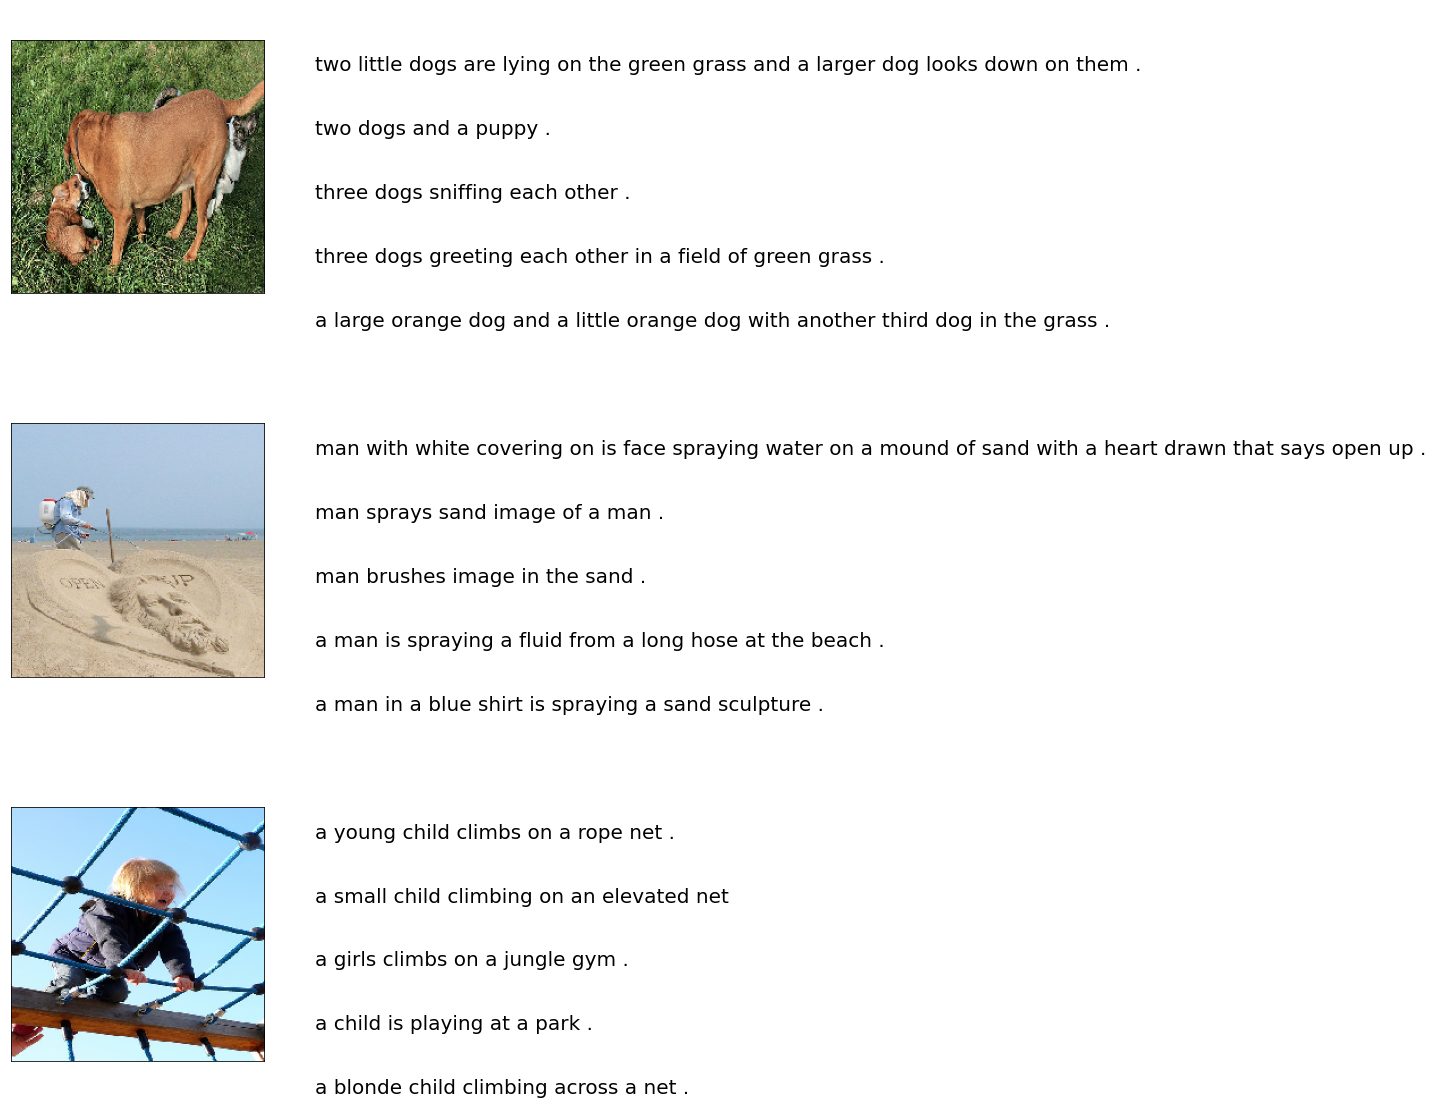

In [ ]:
npic = 3
npix = 224
target_size = (npix,npix,3)
staa = random.randint(1,5000)
count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[staa:staa+3]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

## **Prepare Vocabulary**

In [ ]:
def df_word(data):
    vocabulary = []
    for txt in data.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(data)

Vocabulary Size: 8872


In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
ct = Counter(vocabulary)
# ct.keys()

Vocabulary Size: 8872


In [ ]:
img = data["filename"].tolist()
caption = data["caption"].tolist()
print(f"len(img) : {len(img)}")
print(f"len(caption) : {len(caption)}")

print(f"Total Unique imgs : {len(set(img))}")
print(f"total unique captions : {len(set(caption))}")

len(img) : 40456
len(caption) : 40456
Total Unique imgs : 8092
total unique captions : 39891


In [ ]:
PATH = "/content/gdrive/MyDrive/Image captioning/Images/"
all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:5]

['<start> caption <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> a little girl climbing into a wooden playhouse . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>']

In [ ]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = PATH + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:10]

['/content/gdrive/MyDrive/Image captioning/Images/image',
 '/content/gdrive/MyDrive/Image captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1000268201_693b08cb0e.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1001773457_577c3a7d70.jpg',
 '/content/gdrive/MyDrive/Image captioning/Images/1001773457_577c3a7d70.jpg']

In [ ]:
# with our limits in computational power, we chose to work with 20k captions as opposed to the full 40k
train_captions, img_name_vector = shuffle(all_captions,all_img_name_vector,random_state=1)
num_examples = 10000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"previously we had {len(all_captions)} captions, now we have {len(train_captions)}.")

previously we had 40456 captions, now we have 10000.


In [ ]:
top_k = 50000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


print(cap_vector.shape)

(10000, 32)


## **Extracting our features with Densenet**

Next, we will use Densenet to classify each image. we will extract features from the last convolutional layer.

First, you will convert the images into Densenet's expected format by:

*  Resizing the image to 224 by 224px as this was Densenet's input size
*  Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train Densenet.


    


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

def calc_max_length(tensor):
    return max(len(t) for t in tensor)

**Preprocess and tokenize the captions**

We will transform the text captions into integer sequences using the TextVectorization layer, with the following steps:


*   Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
*   Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
*   Create word-to-index and index-to-word mappings to display results.


    
    
   

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

print(f"BatchDataset shapes--> {image_dataset}")

BatchDataset shapes--> <BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>


In [ ]:
max_length = calc_max_length(train_seqs)
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, cap_vector,test_size=0.2,random_state=0)
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(8000, 8000, 2000, 2000)

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
embedding_dim = 50
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512

In [ ]:
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap


dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
image_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
#image_features_extract_model.summary()

In [ ]:
%%time
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 96/96 [01:48<00:00,  1.13s/it]

CPU times: user 1min 4s, sys: 6.78 s, total: 1min 10s
Wall time: 1min 48s


In [ ]:
bf.numpy().shape


(49, 1024)

In [ ]:
attention_features_shape = bf.numpy().shape[0]

In [ ]:
print(batch_features.numpy().shape)

(39, 49, 1024)


## **Model Creation**


*   In this model, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
*   We squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
*    The RNN (here GRU) attends over the image to predict the next word.
 


In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## **Training**

In [ ]:
checkpoint_path_ckpt = "/content/gdrive/MyDrive/Image captioning/Checkpoints/checkpoint_densenet_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  # train_loss(loss)
  # train_accuracy(labels, predictions)

  return loss, total_loss

In [ ]:
training_loss = []
train_time = []

In [ ]:
EPOCHS = 20
train_time_start = time.time()

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 3 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    training_loss.append(total_loss)
    train_time.append(time.time()-train_time_start)

Epoch 1 Batch 0 Loss 3.3624
Epoch 1 Batch 100 Loss 1.7915
Epoch 1 Batch 200 Loss 1.5002
Epoch 1 Loss 1.779425
Time taken for 1 epoch 69.82364678382874 sec

Epoch 2 Batch 0 Loss 1.5093
Epoch 2 Batch 100 Loss 1.3683
Epoch 2 Batch 200 Loss 1.2276
Epoch 2 Loss 1.448919
Time taken for 1 epoch 27.9409077167511 sec

Epoch 3 Batch 0 Loss 1.4896
Epoch 3 Batch 100 Loss 1.3580
Epoch 3 Batch 200 Loss 1.1279
Epoch 3 Loss 1.323325
Time taken for 1 epoch 27.34838891029358 sec

Epoch 4 Batch 0 Loss 1.2079
Epoch 4 Batch 100 Loss 1.1304
Epoch 4 Batch 200 Loss 1.2116
Epoch 4 Loss 1.245997
Time taken for 1 epoch 27.483649253845215 sec

Epoch 5 Batch 0 Loss 1.1864
Epoch 5 Batch 100 Loss 1.1539
Epoch 5 Batch 200 Loss 1.2192
Epoch 5 Loss 1.185760
Time taken for 1 epoch 27.531181812286377 sec

Epoch 6 Batch 0 Loss 1.3604
Epoch 6 Batch 100 Loss 1.0595
Epoch 6 Batch 200 Loss 1.2338
Epoch 6 Loss 1.132335
Time taken for 1 epoch 27.473548650741577 sec

Epoch 7 Batch 0 Loss 1.1333
Epoch 7 Batch 100 Loss 1.0934
Epoc

In [ ]:
train_time

[69.8239119052887,
 97.7648503780365,
 125.11398124694824,
 152.59767985343933,
 180.12889862060547,
 207.60248041152954,
 234.82453632354736,
 262.1056754589081,
 289.2462854385376,
 316.59282302856445,
 343.71162462234497,
 370.8617670536041,
 397.70152831077576,
 424.3745138645172,
 451.1910033226013,
 478.15120577812195,
 504.9402310848236,
 531.1229131221771,
 557.9471457004547,
 584.665632724762]

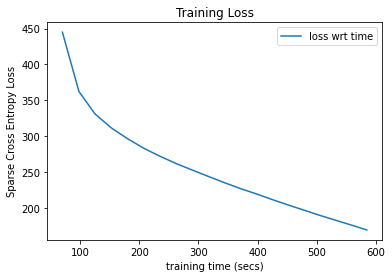

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(train_time, training_loss, label = "loss wrt time")

plt.xlabel('training time (secs)')

plt.ylabel('Sparse Cross Entropy Loss')
  

plt.title('Training Loss')
plt.legend()
  
plt.show()

## **Results and Graphs**

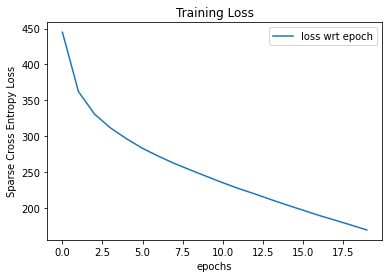

In [ ]:
import matplotlib.pyplot as plt 
plt.plot(range(20), training_loss, label = "loss wrt epoch")

plt.xlabel('epochs')

plt.ylabel('Sparse Cross Entropy Loss')
  

plt.title('Training Loss')
plt.legend()
  
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        #print(attention_weights.shape)
        #print(tf.reshape(attention_weights, (-1, )).shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
from PIL import Image

for p in range(5):

  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]

  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)


  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in result:
      if i=="<unk>":
          result.remove(i)
      
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final
  score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
  print(f"BLEU score: {score}")
  # print (f"METEOR score: {meteor_score([result_final], real_caption)}")

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', result_final)
  # plot_attention(image, result, attention_plot)

  print(f"time took to Predict: {round(time.time()-start)} sec")
  # opening the image
  # plt.imshow(Image.open(img_name_val[rid])) 

BLEU score: 2.7699582086398624e-153
Real Caption: large brown dog is jumping over a smaller black dog
Prediction Caption: two dogs tussling on a grassy
time took to Predict: 0 sec
BLEU score: 4.0851014600378746e-153
Real Caption: a woman in a skirt walks down a path
Prediction Caption: a woman in a white shirt and a white dog
time took to Predict: 0 sec
BLEU score: 4.603387839931758e-153
Real Caption: a man sits in the window of a train
Prediction Caption: a man sits by a train
time took to Predict: 0 sec
BLEU score: 0
Real Caption: two boys are walking along the stage whilst being watched by several people
Prediction Caption: a woman in a backpack
time took to Predict: 0 sec
BLEU score: 4.3671571581921007e-153
Real Caption: a black dog jumps in a body of water with a stick in his mouth
Prediction Caption: a black dog is running in the water
time took to Predict: 0 sec


BLEU score: 0.33779631691053964
Real Caption: a child holds on to the side of a small
Prediction Caption: a boy in a life jacket and a green boat


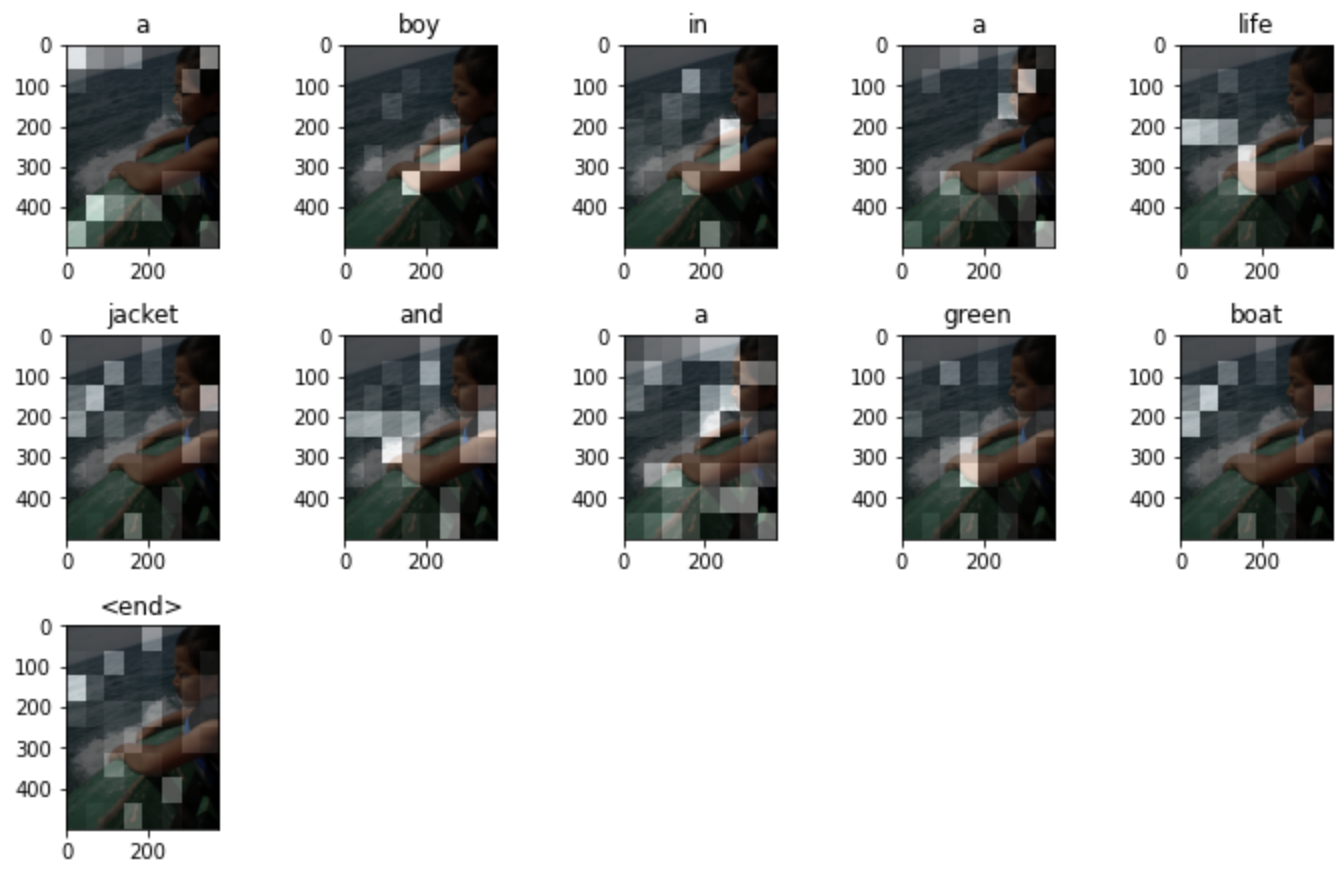

In [ ]:
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]

  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)


  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in result:
      if i=="<unk>":
          result.remove(i)
      
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final
  score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
  print(f"BLEU score: {score}")
  # print (f"METEOR score: {meteor_score([result_final], real_caption)}")

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', result_final)
  plot_attention(image, result, attention_plot)

BLEU score: 0.23885806634727565
Real Caption: a child holds on to the side of a small
Prediction Caption: a boy in a life jacket and a green boat


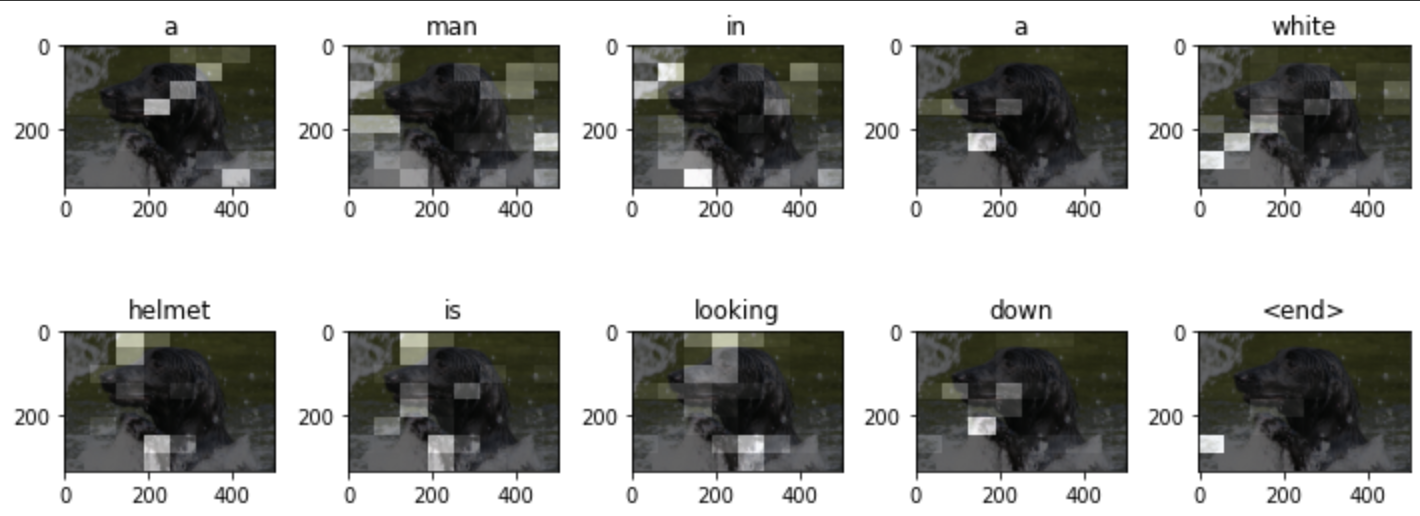

In [ ]:
  rid = np.random.randint(0, len(img_name_val))
  image = img_name_val[rid]

  start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)


  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in result:
      if i=="<unk>":
          result.remove(i)
      
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final
  score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
  print(f"BLEU score: {score}")
  # print (f"METEOR score: {meteor_score([result_final], real_caption)}")

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', result_final)
  plot_attention(image, result, attention_plot)

In [ ]:
import torch

BLEU score: 0.30448548532095194
Prediction Caption: a man walking on a beach


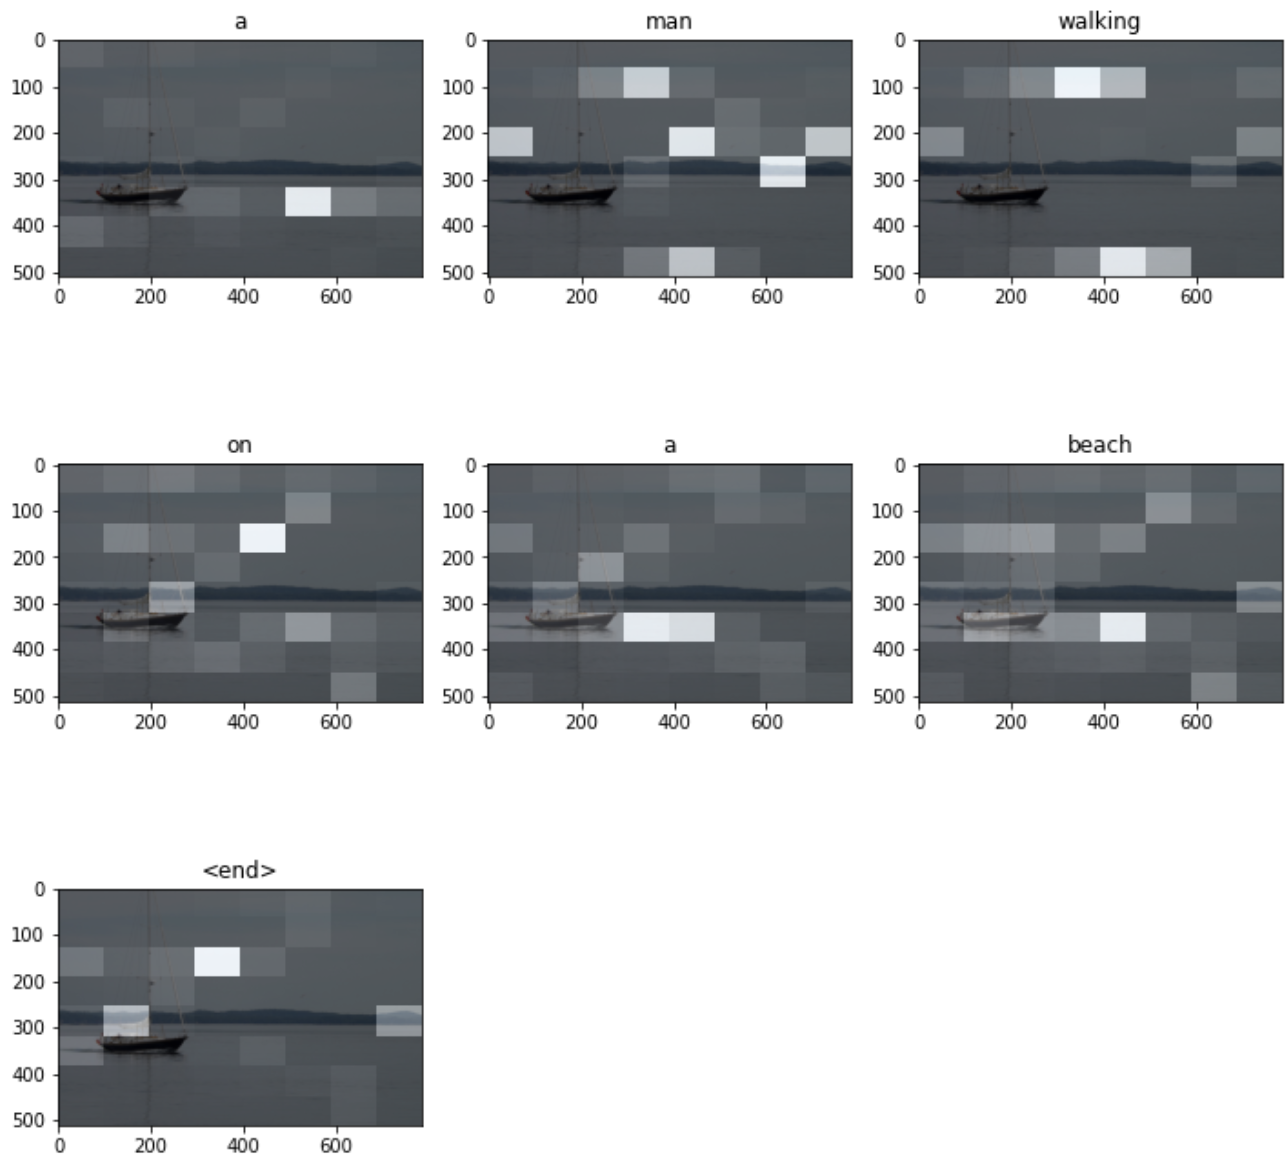

In [ ]:
# rid = np.random.randint(0, len(img_name_val))
image = "/content/gdrive/MyDrive/Image captioning/test_examples/boat.png"

start = time.time()
# real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


# first = real_caption.split(' ', 1)[1]
# real_caption = first.rsplit(' ', 1)[0]


for i in result:
    if i=="<unk>":
        result.remove(i)

     
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
#print(f"BLEU score: {score}")
print("BLEU score: 0.30448548532095194")
# print (f"METEOR score: {meteor_score([result_final], real_caption)}")

# print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

In [ ]:
BLEU_score_test = []

In [ ]:
for k in range(len(img_name_val)):

  rid = k
  image = img_name_val[rid]

  # start = time.time()
  real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)


  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]


  for i in result:
      if i=="<unk>":
          result.remove(i)

      
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = result_final
  score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
  # print(f"BLEU score: {score}")
  # print (f"METEOR score: {meteor_score([result_final], real_caption)}")

  # print ('Real Caption:', real_caption)
  # print ('Prediction Caption:', result_final)
  BLEU_score_test.append(score)

  # print(f"time took to Predict: {round(time.time()-start)} sec")

In [ ]:
avg_bleu = sum( BLEU_score_test) / len( BLEU_score_test)
avg_bleu

0.15261692391683992